In [ ]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(sigma_sigma=[0.1, 0.2, 0.3, 0.4, 0.5],
                                 g=[3, 6, 10],
                                 alpha_value=[0.5, 1])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [7]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = params['g']
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [ ]:
#Network size
R = 2
sigma_sigma = params['sigma_sigma']
N_tasks = 2500
alpha = N_tasks / N
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
all_loadings = np.zeros((N_tasks, N, 2*R))
sigma_mn_all = np.random.normal(0, sigma_sigma, (R, R, N_tasks))/N
#ensure positive definiteness
sigma_mm = np.eye(R)/N
sigma_nn = np.eye(R)/N
for i_task in range(N_tasks):
    sigma_mn = sigma_mn_all[:,:,i_task]
    covariance_top = np.hstack([sigma_mm, sigma_mn])
    covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
    covariance = np.vstack([covariance_top, covariance_bot])
    eigs, vecs = np.linalg.eigh(covariance)
    while not (eigs > 0).all():
        sigma_mn = np.random.normal(0, sigma_sigma, (R, R))/N
        covariance_top = np.hstack([sigma_mm, sigma_mn])
        covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
        covariance = np.vstack([covariance_top, covariance_bot])
        eigs, vecs = np.linalg.eigh(covariance)
        sigma_mn_all[:,:,i_task] = sigma_mn

In [ ]:
def sample_W_optimized(sigma_mn_all, D, N):
    # Use CPU or GPU depending on availability
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 0
    
    # Get dimensions
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    
    # Convert inputs to torch tensors with appropriate dtype
    sigma_mn_all = torch.from_numpy(sigma_mn_all.astype(np.float32)).to(device)  # (R, R, N_tasks)
    D_tensor = torch.from_numpy(D.astype(np.float32)).to(device)  # (N_tasks,)
    
    # Create identity matrices for sigma_mm and sigma_nn
    sigma_mm = torch.eye(R, dtype=torch.float32, device=device).unsqueeze(2).repeat(1,1,N_tasks)  # (R, R, N_tasks)
    sigma_nn = torch.eye(R, dtype=torch.float32, device=device).unsqueeze(2).repeat(1,1,N_tasks)
    
    # Build full covariance matrices for all tasks
    covariance_top = torch.cat([sigma_mm, sigma_mn_all], dim=1)  # (R, 2R, N_tasks)
    covariance_bot = torch.cat([sigma_mn_all.transpose(0,1), sigma_nn], dim=1)  # (R, 2R, N_tasks)
    covariance = torch.cat([covariance_top, covariance_bot], dim=0)  # (2R, 2R, N_tasks)
    covariance = (1 / N) * covariance  # Scale by (1/N)
    
    # Mean vector (zero mean) for all tasks
    mean = torch.zeros(2 * R, N_tasks, dtype=torch.float32, device=device)  # (2R, N_tasks)
    
    # Create multivariate normal distributions for each task
    mvn = torch.distributions.MultivariateNormal(
        mean.T,  # (N_tasks, 2R)
        covariance_matrix=covariance.permute(2,0,1)  # (N_tasks, 2R, 2R)
    )
    
    # Sample loadings: Shape (N_tasks, N, 2R)
    loadings = mvn.rsample((N,))  # (N, N_tasks, 2R)
    loadings = loadings.permute(1, 0, 2)  # (N_tasks, N, 2R)
    
    # Split loadings into two parts
    loadings_m = loadings[:, :, :R]  # (N_tasks, N, R)
    loadings_n = loadings[:, :, R:]  # (N_tasks, N, R)
    
    # Multiply loadings_m by D
    D_expanded = D_tensor[:, None, None]  # (N_tasks, 1, 1)
    loadings_m_weighted = D_expanded * loadings_m  # (N_tasks, N, R)
    
    # Reshape loadings_m_weighted and loadings_n to (N, N_tasks * R)
    loadings_m_weighted_flat = loadings_m_weighted.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)
    loadings_n_flat = loadings_n.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)
    
    # Compute W = loadings_m_weighted_flat @ loadings_n_flat.T
    W = loadings_m_weighted_flat @ loadings_n_flat.T  # (N, N)
    
    return W, loadings.cpu().numpy()

W_, all_loadings = sample_W_optimized(sigma_mn_all*N, D, N)

In [ ]:
# def sample_W(sigma_mn_all, D, N):
#     W = 0
#     R = sigma_mn_all.shape[0]
#     N_tasks = sigma_mn_all.shape[2]
#     for i_task in range(N_tasks):
#         sigma_mm = np.eye(R)/N
#         sigma_nn = np.eye(R)/N
#         sigma_mn = sigma_mn_all[:,:,i_task]
#         covariance_top = np.hstack([sigma_mm, sigma_mn])
#         covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
#         covariance = np.vstack([covariance_top, covariance_bot])

#         loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
#         all_loadings[i_task] = loadings
#         W_task = D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])
#         W += W_task
#     W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
    
#     return W_, all_loadings

In [ ]:
#W_, all_loadings = sample_W(sigma_mn_all, D, N)

In [ ]:
N_W_samples = 10
C_emp_avg = 0
for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all*N, D, N)
    
    ### --- Estimate C empirically --- ###

    #lags window
    T_window_emp = 120
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)
    if True:
        x, r = sample_activity(T_sim=10000, dt_save=dT_emp, dt=0.1, W=W_, phi_torch=phi_torch,
                               runga_kutta=True, T_save_delay=1000)
        r = torch.from_numpy(r).type(torch.FloatTensor).to(0)[:,None,:]
        C_emp_unit = compute_lagged_xcov(r, r, lags_emp, dt_save=dT_emp)

        #symmetrize C_emp for comparison
        C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
        C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
        lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    else:
        lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
        C_emp = np.zeros_like(lags_emp_full)
    C_emp_avg += C_emp / N_W_samples

In [ ]:
### --- Set theory parameters --- ###
T_window = 120
#T_window = 60
#dT = 0.02
#dT = 0.04
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([lags, np.array([lags[-1]]), -lags[1:][::-1]])

In [ ]:
#sigma_mn_all_flat = np.vstack(sigma_mn_all)

In [ ]:
# dt=0.05
# d = torch.tensor(D).to(0)
# C_rr = torch.tensor(sigma_mn_all_flat).to(0)
# C_ft, S_ft = (uni_rfft(param, dt) for param in (C_dmft, S_dmft))

# I = torch.tensor([1, 0, 0, 1], dtype=torch.float32).to(0)
# Z_inv = I[None,:,None] - np.sqrt(2*np.pi)*d[None,None,:]*C_rr[None,:,:]*S_ft[:,None,None]
# det = Z_inv[:,0,:]*Z_inv[:,3,:] - Z_inv[:,1,:]*Z_inv[:,2,:]
# Z = torch.stack([Z_inv[:,3,:], -Z_inv[:,1,:], -Z_inv[:,2,:], Z_inv[:,0,:]], dim=1) / det[:,None,:]
# Q_r_sum_ft = alpha * (d**2 * torch.sum(torch.abs(Z)**2, dim=1)).mean(-1) * C_ft
# R_ft = alpha*torch.sum(d*C_rr[None,(0,2,1,3),:] * torch.conj(Z), dim=1).mean(-1)/np.sqrt(2*np.pi)

# Q_r_sum, R = (uni_irfft(param, dt) for param in (Q_r_sum_ft, R_ft))

# eta = sample_gp(Q_r_sum, N_samples, C_in_fourier=False)
# nk = int(50 / dt)
# x = run_dynamics(eta, dt=dt, kernel=R[:nk])
# phi = phi_torch(x)

In [ ]:
#res = torch.einsum('wikn, wkjn -> wijn', Z.reshape((2401, 2, 2, 2000)), Z_inv.reshape((2401, 2, 2, 2000)))

In [ ]:
#sigma_mn_all_flat

In [ ]:
#plt.plot(R.cpu())

In [ ]:
#plt.hist(W_.cpu().numpy().flatten(), bins=100)

In [ ]:
sigma_mn_all_flat = np.vstack(sigma_mn_all)
N_samples = 10000
num_iter = 400
final_avg_iter = 50
#run DMFT solver loop
C_dmft, S_dmft = util.solve_dmft(
    update_fn=(lambda C, S:
               update_extensive_tasks_2x2(torch.tensor(D).to(0),
                                   N*torch.tensor(sigma_mn_all_flat).to(0),
                                   C, S, N_samples=N_samples, dt=dT, alpha=params['alpha_value'])),
    callback_fn=None,
    init_dt=dT,
    N_t=int((2*T_window)/dT),
    num_iter=num_iter,
    device=0,
    alpha=0.8,
    final_avg_iter=final_avg_iter)

In [ ]:
C_numpy = C_dmft.cpu().detach().numpy()
S_numpy = S_dmft.cpu().detach().numpy()

In [ ]:
def upsample_array(arr, ratio):
    # Calculate the number of points in the upsampled array
    new_length = int(len(arr) * ratio)
    
    # Create the new array by interpolating values
    x_original = np.arange(len(arr))
    x_new = np.linspace(0, len(arr) - 1, new_length)
    upsampled_arr = np.interp(x_new, x_original, arr)
    
    return upsampled_arr

In [ ]:
C_up = upsample_array(C_emp_avg, int(dT_emp/dT))

In [ ]:
processed_data = np.array([S_numpy, C_numpy, C_up])
#processed_data = np.array([R_, R1_, R2_])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [38]:
###Truncate file above
file_name = 'extensive_tasks_match'
job_name = 'sigma_sigma_g_alpha'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook extensive_tasks_match.ipynb to script
[NbConvertApp] Writing 32664 bytes to extensive_tasks_match.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac775d39bd0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac775d39bd0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [39]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='PRL_Submission')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='PRL_Submission', lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/PRL_Submission/sigma_sigma_g_alpha/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/cluster/
mft-theory/cluster/__

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [3]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'sigma_sigma_g_alpha'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
job_name = 'LDR_sym_PR_match_rho_sim_final_5'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [5]:
theory_results[0]

{'sigma_sigma': [0.1, 0.2, 0.3, 0.4, 0.5],
 'g': [3, 6, 10],
 'alpha_value': [0.5, 1],
 'i_seed': [0]}

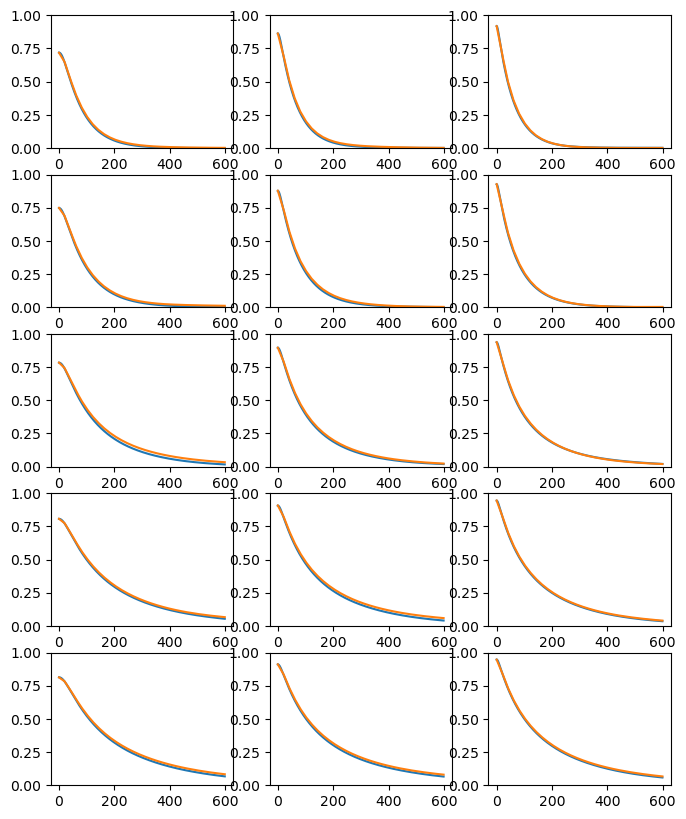

In [7]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(8, 10))
for i in range(5):
    for j in range(3):
        ax[i,j].plot(theory_results[1][i,j,0,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][i,j,0,0,2,:600], color='C1')
        ax[i,j].set_ylim([0, 1])

In [40]:
smn_all = theory_results[3]['0.5_6_False_0']

In [57]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)
#Network size
R = 2
sigma_sigma = 0.5
N_tasks = 5000
alpha = N_tasks / N
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
def sample_W(sigma_mn_all, D, N):
    W = 0
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    all_loadings = np.zeros((N_tasks, N, 2*R))
    for i_task in range(N_tasks):
        sigma_mm = np.eye(R)
        sigma_nn = np.eye(R)
        sigma_mn = sigma_mn_all[:,:,i_task]
        covariance_top = np.hstack([sigma_mm, sigma_mn])
        covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
        covariance = (1/N)*np.vstack([covariance_top, covariance_bot])

        loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
        all_loadings[i_task] = loadings
        W_task = D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])
        W += W_task
    W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
    
    return W_, all_loadings

#W_, all_loadings = sample_W(smn_all*N, D, N)

In [58]:
def sample_W_optimized(sigma_mn_all, D, N):
    # Use CPU or GPU depending on availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 0
    
    # Get dimensions
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    
    # Convert inputs to torch tensors with appropriate dtype
    sigma_mn_all = torch.from_numpy(sigma_mn_all.astype(np.float32)).to(device)  # (R, R, N_tasks)
    D_tensor = torch.from_numpy(D.astype(np.float32)).to(device)  # (N_tasks,)
    
    # Create identity matrices for sigma_mm and sigma_nn
    sigma_mm = torch.eye(R, dtype=torch.float32, device=device).unsqueeze(2).repeat(1,1,N_tasks)  # (R, R, N_tasks)
    sigma_nn = torch.eye(R, dtype=torch.float32, device=device).unsqueeze(2).repeat(1,1,N_tasks)
    
    # Build full covariance matrices for all tasks
    covariance_top = torch.cat([sigma_mm, sigma_mn_all], dim=1)  # (R, 2R, N_tasks)
    covariance_bot = torch.cat([sigma_mn_all.transpose(0,1), sigma_nn], dim=1)  # (R, 2R, N_tasks)
    covariance = torch.cat([covariance_top, covariance_bot], dim=0)  # (2R, 2R, N_tasks)
    covariance = (1 / N) * covariance  # Scale by (1/N)
    
    # Mean vector (zero mean) for all tasks
    mean = torch.zeros(2 * R, N_tasks, dtype=torch.float32, device=device)  # (2R, N_tasks)
    
    # Create multivariate normal distributions for each task
    mvn = torch.distributions.MultivariateNormal(
        mean.T,  # (N_tasks, 2R)
        covariance_matrix=covariance.permute(2,0,1)  # (N_tasks, 2R, 2R)
    )
    
    # Sample loadings: Shape (N_tasks, N, 2R)
    loadings = mvn.rsample((N,))  # (N, N_tasks, 2R)
    loadings = loadings.permute(1, 0, 2)  # (N_tasks, N, 2R)
    
    # Split loadings into two parts
    loadings_m = loadings[:, :, :R]  # (N_tasks, N, R)
    loadings_n = loadings[:, :, R:]  # (N_tasks, N, R)
    
    # Multiply loadings_m by D
    D_expanded = D_tensor[:, None, None]  # (N_tasks, 1, 1)
    loadings_m_weighted = D_expanded * loadings_m  # (N_tasks, N, R)
    
    # Reshape loadings_m_weighted and loadings_n to (N, N_tasks * R)
    loadings_m_weighted_flat = loadings_m_weighted.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)
    loadings_n_flat = loadings_n.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)
    
    # Compute W = loadings_m_weighted_flat @ loadings_n_flat.T
    W = loadings_m_weighted_flat @ loadings_n_flat.T  # (N, N)
    
    return W.cpu().numpy(), loadings.cpu().numpy()

D_changed = D.copy()
D_changed[0] *= 3
W_, all_loadings = sample_W_optimized(smn_all*N, D_changed, N)

In [59]:
W_ = torch.from_numpy(W_).to(0)

In [60]:
eigs, vecs = np.linalg.eig(W_.cpu().numpy())

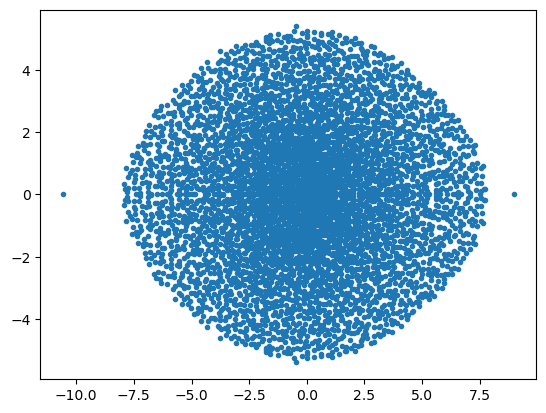

In [61]:
plt.plot(eigs.real, eigs.imag, '.')

In [62]:
x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=1000)

In [63]:
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]

In [59]:
S_ft = uni_rfft(S, dt=0.05)

In [60]:
M_omega = D[0]*C_rr.cpu().numpy()[:,:,None]*(S_ft.cpu().numpy()[None,None,:])

In [67]:
np.abs(np.linalg.eig(D[0]*C_rr.cpu().numpy() * S_ft.cpu().numpy()[0])[0])

array([0.1021046 , 0.16012001], dtype=float32)

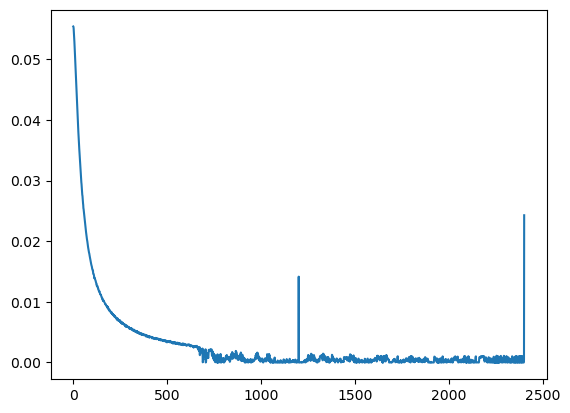

In [63]:
plt.plot(torch.abs(S_ft.cpu()))

[[ 1.28560542e-04 -4.75478075e-07]
 [ 1.05981195e-05 -1.57478484e-04]]


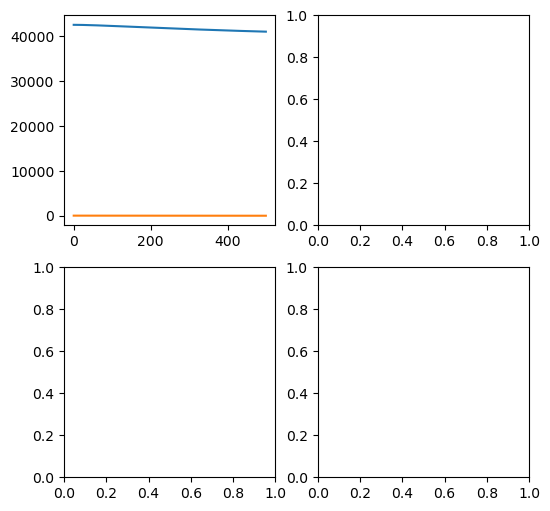

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * torch.tensor(theory_results[1][4,1,0,0,1], dtype=torch.float32).to(0)
    S = torch.tensor(theory_results[1][4,1,0,0,0], dtype=torch.float32).to(0)
    C_rr = N*torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

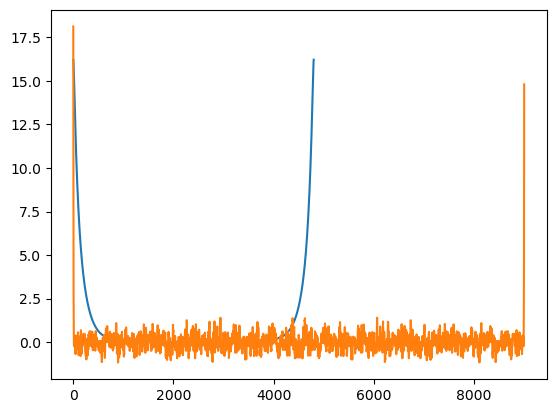

In [27]:
plt.plot(D2Cphi.cpu())
plt.plot(z_acov[:,0])

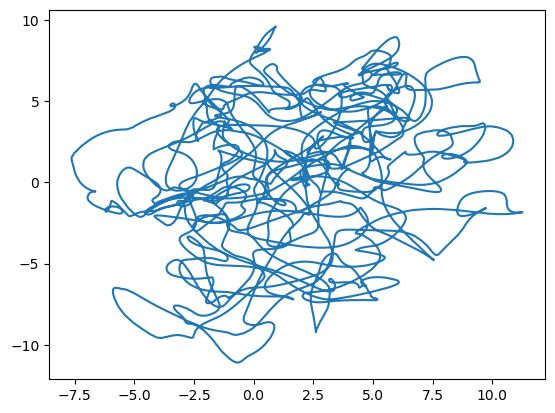

In [28]:
plt.plot(sim_eta_z.cpu()[0], sim_eta_z.cpu()[1])

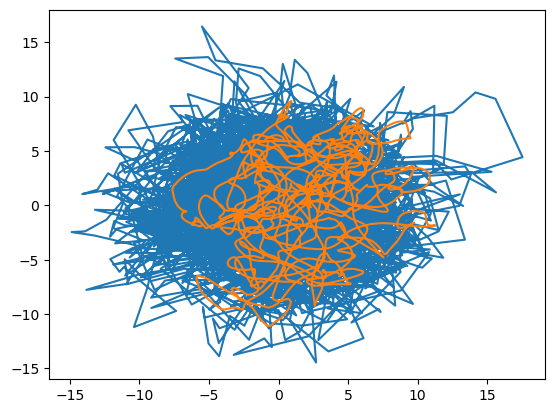

In [30]:
plt.plot(Z[i_task,:4800,0], Z[i_task,:4800,1])
plt.plot(Z_sim[0], Z_sim[1])

In [22]:
def run_z_dynamics(eta, dt, d, C_rr, kernel=None):
    N_z, N_t = eta.shape
    pad = N_t // 2
    z = torch.zeros(N_z, N_t + pad).to(eta.device)
    eta_pad = torch.zeros(N_z, N_t + pad).to(eta.device)
    eta_pad[:, :pad] = eta[:, N_t - pad:]
    eta_pad[:, pad:] = eta
    eta = eta_pad
    z[:, 0] = torch.randn(N_z, device=eta.device)

    nk = len(kernel) if kernel is not None else 0

    for i in range(1, N_t + pad):
        start = max(0, i - nk)
        nk_stop = i - start
        kernel_contribution = dt * torch.trapz(
            torch.flip(z[:, start:i], dims=(1,)) * kernel[None, :nk_stop], dim=1
        ) if nk_stop > 0 else 0.0
        z[:, i] = eta[:, i] + d * torch.matmul(C_rr, kernel_contribution)

    return z[:, pad:]

In [ ]:
S = torch.tensor(theory_results[1][4,1,0,0], dtype=torch.float32).to(0)
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
Z_sim = run_z_dynamics(sim_eta_z, dt=0.1, d=D[0], C_rr=C_rr, kernel=S)

In [ ]:
Z_sim.shape

In [ ]:
ccw_scores = []
fig, ax = plt.subplots(3, 5, figsize=(6, 4))
ax = ax.flatten()
for i_task in range(15): 
    x = Z[i_task,:100,0]
    y = Z[i_task,:100,1]
    ax[i_task].plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    for i in range(0, len(x) - skip, skip):
        ax[i_task].arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
                  shape='full', lw=2, length_includes_head=False, head_width=3)
    

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(20, 6))
for i in range(0, 27, 3):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        ax[j,i//3].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[j,i//3].set_ylim([-0.5, 0.5])
        ax[j,i//3].set_xlim([-1, 150])
    ax[0,i//3].set_title('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(27, 3, figsize=(12, 38))
for i in range(0, 27, 1):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        #ax[i,j].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[i,j].plot(R/R[1])
        ax[i,j].set_ylim([-1.2, 1.2])
        ax[i,j].set_xlim([-1, 150])
        ax[0,j].set_title('u shift = {}'.format(theory_results[0]['t_shift'][j]))
    ax[i,0].set_ylabel('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(9, 3, figsize=(5, 15))
for i in range(27):
    ax[i%9, i//9].plot(np.squeeze(theory_results[1])[i,0])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6.8, 2))
cols = ['#CCB966', '#EA696A', '#336E96']
for i in range(3):
    for j in range(3):
        s = sim_results[1][:,i,j,:,0].mean(1)
        ax[i].plot(sim_results[0]['rho_1'], s, '.', color=cols[j])
        t = theory_results[1][:,i,j,0,1]
        sing_unit_fit = theory_results[1][:,i,j,0,2]
        #c_fit = theory_results[1][:,i,j,0,2]
        ax[i].plot(theory_results[0]['rho_1'], t, color=cols[j])
        ax[i].plot(theory_results[0]['rho_1'], sing_unit_fit, color='k')
        #ax[i].plot(theory_results[0]['rho_1'], c_fit, color='k')
    ax[i].set_ylim([0, 0.07])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(5):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,2], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_1$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
sim_results[0]
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
for i in range(5):
    ax[i].plot(sim_results[0]['rho_max'], sim_results[1][:,i,:,0].mean(-1), '.')
    ax[i].set_ylim([0, 0.1])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_max'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_max'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_max'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{max}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_offset'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{offset}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')


In [ ]:
plt.hist(np.log10(theory_results[1][:,:,:,2].flatten()))

In [ ]:
plt.figure(figsize=(4, 4))
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,1], color='k')
plt.xticks([-0.8, 0, 0.8])
plt.xlabel('$rho$')
plt.ylabel('PR')
plt.ylim([0, 0.1])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 1
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])